# Debugging

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import math
import torchvision
import torch.nn.functional as F
import numpy as np
from torch.nn.parameter import Parameter

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class SubspaceLinear(nn.Module):
    def __init__(
        self,
        in_features, out_features, 
        subspace_features, # this is new!
        bias: bool = True, # the rest is by the numbers
        device = None,
        dtype = None
    ):
        factory_kwargs = {"device": device, "dtype": dtype}

        super().__init__() 
        
        # Mirror nn.Linear init
        self.in_features = in_features
        self.out_features = out_features
        self.subspace_features = subspace_features
        
        # Not a Parameter!
        self.theta = torch.empty((out_features, in_features), **factory_kwargs)
        
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        nn.init.kaiming_uniform_(self.theta, a=math.sqrt(5))

        # After init, save fixed weights
        self.theta_zero = self.theta.detach().clone()
        
        # Generate projection matrix
        self.proj_mat = torch.empty((out_features, subspace_features), **factory_kwargs)
        # TODO: Init this properly
        
        # Init theta prime, which will be actually used
        self.theta_prime = Parameter(torch.empty((subspace_features, in_features), **factory_kwargs))
    
        # According to https://pytorch.org/docs/stable/generated/torch.nn.functional.linear.html
        # Weight has shape (out_features, in_features)
        # Therefore P x theta_prime is:
        # (out_features, subspace_features) X (subspace_features, in_features)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        
        nn.init.kaiming_uniform_(self.theta_prime, a=math.sqrt(5))
        
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.theta)
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            nn.init.uniform_(self.bias, -bound, bound)
        
    def forward(self, x):
        # in nn.Linear:
        # return F.linear(x, self.weight, self.bias)
        theta = self.theta_zero + torch.mm(self.proj_mat, self.theta_prime)
        return F.linear(x, theta, self.bias)
    
    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, subspace_features={}, bias={}'.format(
            self.in_features, self.out_features, self.subspace_features, self.bias is not None
        )

## Synthetic data

In [17]:
sample_x = np.random.uniform(size=(1000, 1))
sample_y = sample_x ** 2

In [18]:
sample_x = torch.Tensor(sample_x)
sample_y = torch.Tensor(sample_y)

## Explore differences with linear

In [19]:
linear = nn.Linear(1, 1)
sslinear = SubspaceLinear(1, 1, subspace_features=1)

In [21]:
lin_out = linear(sample_x)

In [23]:
sslin_out = sslinear(sample_x)

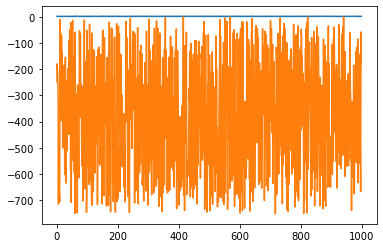

In [26]:
plt.plot(lin_out.detach().numpy())
plt.plot(sslin_out.detach().numpy())

Poor init! Gotta fix it.

In [27]:
linear.weight

Parameter containing:
tensor([[0.9847]], requires_grad=True)

In [28]:
linear.bias

Parameter containing:
tensor([0.8897], requires_grad=True)

In [29]:
sslinear.theta

tensor([[0.2560]])

In [30]:
sslinear.bias

Parameter containing:
tensor([0.2721], requires_grad=True)

In [31]:
sslinear.theta_prime

Parameter containing:
tensor([[0.8092]], requires_grad=True)

In [32]:
sslinear.proj_mat

tensor([[-931.4570]])

The culprit is caught red-handed! I forgot to init the projection matrix.